<a href="https://colab.research.google.com/github/Lisius96/AMDRiccardiProject/blob/main/ProgettoAMDRiccardi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

In [ ]:
!pip install findspark

In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget -q https://archive.apache.org/dist/spark/spark-3.4.1/spark-3.4.1-bin-hadoop3.tgz

In [ ]:
!tar xvf spark-3.4.1-bin-hadoop3.tgz

In [ ]:
!pip install sparknlp

In [7]:
import os

In [8]:
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.4.1-bin-hadoop3"

In [9]:
import findspark
findspark.init("/content/spark-3.4.1-bin-hadoop3")

In [10]:
os.environ['KAGGLE_USERNAME'] = "xxxxxx"
os.environ['KAGGLE_KEY'] = "xxxxxx"
!kaggle datasets download -d yelp-dataset/yelp-dataset


100% 4.07G/4.07G [02:03<00:00, 27.1MB/s]
100% 4.07G/4.07G [02:03<00:00, 35.4MB/s]


In [11]:
import zipfile
import pandas as pd
import sparknlp

In [12]:
import functools

In [13]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext
from pyspark.sql import DataFrame
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

In [14]:
from pyspark.sql.functions import col
from pyspark.sql.functions import rand

In [15]:
from pyspark.ml.feature import IDF # vectorizer
from pyspark.ml.feature import StopWordsRemover # to remove stop words
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.classification import MultilayerPerceptronClassifier
from sklearn.metrics import classification_report

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

**CREATE SPARK SESSION**

In [ ]:
spark = sparknlp.start()

**EXTRACT FILES FROM YELP-DATASET**

In [18]:
with zipfile.ZipFile("./yelp-dataset.zip", "r") as z:
    z.extractall(path="./")

**READ FILE CONTAINING REVIEWS**

In [19]:
df = spark.read.json("yelp_academic_dataset_review.json")

In [ ]:
df.show(3)


+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|XQfwVwDr-v0ZS3_Cb...|   0|2018-07-07 22:09:11|    0|KU_O5udG6zpxOg-Vc...|  3.0|If you decide to ...|     0|mh_-eMZ6K5RLWhZyI...|
|7ATYjTIgM3jUlt4UM...|   1|2012-01-03 15:28:18|    0|BiTunyQ73aT9WBnpR...|  5.0|I've taken a lot ...|     1|OyoGAe7OKpv6SyGZT...|
|YjUWPpI6HXG530lwP...|   0|2014-02-05 20:30:30|    0|saUsX_uimxRlCVr67...|  3.0|Family diner. Had...|     0|8g_iMtfSiwikVnbP2...|
|kxX2SOes4o-D3ZQBk...|   1|2015-01-04 00:01:03|    0|AqPFMleE6RsU23_au...|  5.0|Wow!  Yummy, diff...|     1|_7bHUi9Uuf5__HHc_...|
|e4Vwtrqf-wpJfwesg...|   1|2017-01-14 20:54:15|    0|Sx8TMOWLNuJBWer-0...|  4.0|Cute inter

**CREATING BALANCE DATASETS FOR EACH STARS AND THEN MERGE THEM**

In [20]:
num_rows = 20000

In [21]:
df1 = df.where(df.stars==1.0).limit(num_rows)
df2 = df.where(df.stars==2.0).limit(num_rows)
df3 = df.where(df.stars==3.0).limit(num_rows)
df4 = df.where(df.stars==4.0).limit(num_rows)
df5 = df.where(df.stars==5.0).limit(num_rows)

In [22]:
def unionAll(dfs):
    return functools.reduce(lambda df1, df2: df1.union(df2.select(df1.columns)), dfs)

In [23]:
unioned_df = unionAll([df1, df2, df3, df4, df5])

In [ ]:
unioned_df.show(3)

+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|         business_id|cool|               date|funny|           review_id|stars|                text|useful|             user_id|
+--------------------+----+-------------------+-----+--------------------+-----+--------------------+------+--------------------+
|04UD14gamNjLY0IDY...|   1|2015-09-23 23:10:31|    2|JrIxlS1TzJ-iCu79u...|  1.0|I am a long term ...|     1|eUta8W_HdHMXPzLBB...|
|jNL5KUPz2-tHUJM__...|   0|2014-08-24 20:14:12|    0|TcCcHzc3L6Aboq3Dt...|  1.0|If you want to pa...|     1|OuatwND396ZQxm2zK...|
|pAgtmlIGqFYaWdBoC...|   0|2012-12-04 02:40:49|    0|qdzNocGBnh8U-cvE_...|  1.0|The TV shows are ...|     3|Fq7d14GDAsGjDoojP...|
|Wy8Hswf2cLQGRZN6a...|   0|2011-08-24 23:07:08|    0|PDHRlnEdkEcwATry4...|  1.0|If I could give i...|     1|UsBxLh14sUpO8Sdeq...|
|aY_n9RSaD2Yw09jSF...|   0|2017-08-16 15:43:19|    0|5obXxR0b94b5q6j1z...|  1.0|We visited

Shuffling data, otherwise all rows of a single rating value are close each other

In [24]:
unioned_df = unioned_df.withColumn('rand', rand(seed=42)).orderBy('rand')

In [25]:
unioned_df = unioned_df.select("stars", "text")

In [ ]:
unioned_df.show(3)

+-----+--------------------+
|stars|                text|
+-----+--------------------+
|  3.0|Second time's the...|
|  4.0|This place does a...|
|  3.0|everything else i...|
|  2.0|I've been a membe...|
|  2.0|I'm giving this p...|
|  2.0|First off-This ho...|
|  4.0|If you are lookin...|
|  2.0|Much better secon...|
|  2.0|Good food, horrib...|
|  5.0|I I had an amazin...|
+-----+--------------------+
only showing top 10 rows



**PREDICTION USING TF.IDF WITH MLP**

PREPROCESSING

In [26]:
#Different preprocessing steps
assembler = DocumentAssembler()\
  .setInputCol('text')\
  .setOutputCol('document')

sentence = SentenceDetector()\
  .setInputCols(["document"])\
  .setOutputCol("sentences")

tokenizer = Tokenizer()\
  .setInputCols(['sentences'])\
  .setOutputCol('tokens')

lemmatizer = LemmatizerModel.pretrained()\
  .setInputCols(['tokens'])\
  .setOutputCol('lemma')

normalizer = Normalizer()\
  .setInputCols(['lemma'])\
  .setOutputCol('normalized')\
  .setLowercase(True)

finisher = Finisher()\
  .setInputCols(['normalized'])\
  .setOutputCols(['normalized'])\
  .setOutputAsArray(True)

stopwords = set(StopWordsRemover.loadDefaultStopWords('english'))
sw_remover = StopWordsRemover()\
  .setInputCol('normalized')\
  .setOutputCol('filtered')\
  .setStopWords(list(stopwords))

features = 6500

count_vectorizer = CountVectorizer(
  inputCol = 'filtered',
  outputCol = 'raw_features',
  minDF = 2,
  vocabSize = features
  )

idf = IDF(inputCol="raw_features", outputCol="features")

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


Multi-layer perceptron inizialization

In [27]:
mlpc=MultilayerPerceptronClassifier( featuresCol='features',labelCol='stars', predictionCol= 'prediction', layers = [features,32,5],\
                                    maxIter=80, blockSize=32, stepSize = 0.0001, seed=7, solver='l-bfgs')

Creating pipeline with several stages

In [28]:
text_processing_pipeline = Pipeline(
  stages = [
    assembler,
    sentence,
    tokenizer,
    lemmatizer,
    normalizer,
    finisher,
    sw_remover,
    count_vectorizer,
    idf,
    mlpc
   ])

Decreasing values of stars because MLP accepts only label in [0,5)

In [29]:
unioned_df = unioned_df.withColumn("stars", col("stars")-1.0)

Split dataset in training, validation e test sets

In [30]:
training, validation, test = unioned_df.randomSplit([0.7, 0.3, 0.15], seed=123)

Apply the pipeline with its stages

In [31]:
model = text_processing_pipeline.fit(training)

Obtaining prediction from validation set

In [32]:
val = model.transform(validation)

In [33]:
pandval = val.select("stars","prediction").toPandas()

In [34]:
print(classification_report(pandval.stars, pandval.prediction))

              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82      5262
         1.0       0.74      0.77      0.75      5098
         2.0       0.76      0.75      0.76      5343
         3.0       0.76      0.76      0.76      5259
         4.0       0.82      0.84      0.83      5121

    accuracy                           0.79     26083
   macro avg       0.79      0.79      0.79     26083
weighted avg       0.79      0.79      0.79     26083



**EVALUATE RESULTS WITH SEVERAL METRICS**

Obtaining prediction from test set

In [35]:
pred = model.transform(test)

In [36]:
pandpred = pred.select("stars","prediction").toPandas()

Method to obtain ROC AUC for multi-class classification

In [37]:
from sklearn.metrics import roc_auc_score

def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:

        #creating a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [38]:
roc_auc_dict = roc_auc_score_multiclass(pandpred.stars, pandpred.prediction)
roc_auc_dict

{0.0: 0.8999840827842263,
 1.0: 0.8470472193930602,
 2.0: 0.8419362831720988,
 3.0: 0.8569542829792203,
 4.0: 0.9013773655167994}

Accuracy, precision, recall, f1-score and Accuracy for test set

In [39]:
print(classification_report(pandpred.stars, pandpred.prediction))

              precision    recall  f1-score   support

         0.0       0.83      0.84      0.84      2622
         1.0       0.77      0.75      0.76      2604
         2.0       0.75      0.75      0.75      2569
         3.0       0.77      0.77      0.77      2587
         4.0       0.84      0.84      0.84      2615

    accuracy                           0.79     12997
   macro avg       0.79      0.79      0.79     12997
weighted avg       0.79      0.79      0.79     12997



Confusion Matrix

In [40]:
from pyspark.sql.types import FloatType
from pyspark.mllib.evaluation import MulticlassMetrics

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

In [42]:
preds_and_labels = pred.select(['prediction','stars'])\
                              .withColumn('stars', col('stars')\
                              .cast(FloatType()))\
                              .orderBy('prediction')

In [ ]:
metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))

Text(58.222222222222214, 0.5, 'True Labels')

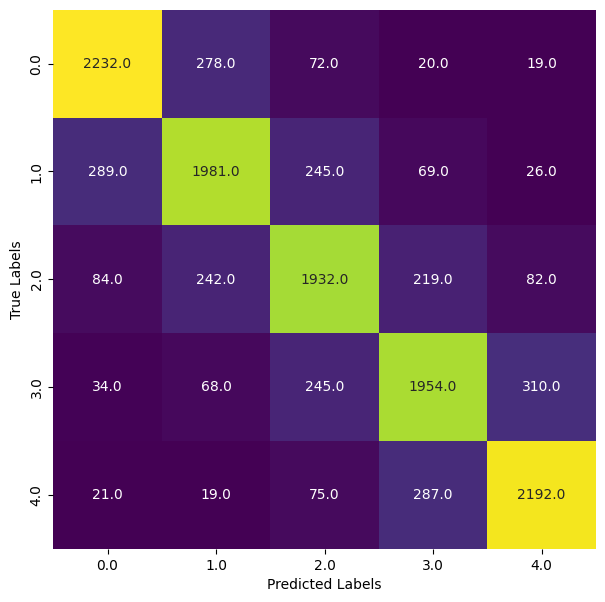

In [44]:
labels = ["0.0", "1.0", "2.0","3.0", "4.0"]
_ = plt.figure(figsize=(7, 7))

sns.heatmap(metrics.confusionMatrix().toArray(),
            cmap='viridis',
            annot=True,fmt='0',
            cbar=False,
            xticklabels=labels,
            yticklabels=labels)

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

F1-score, Precision, Recall, Accuracy for training

In [45]:
train_output_df = model.transform(training)

In [46]:
train_predictionAndLabels = train_output_df.select('prediction', 'stars').toPandas()

In [47]:
print(classification_report(train_predictionAndLabels.stars, train_predictionAndLabels.prediction))

              precision    recall  f1-score   support

         0.0       0.84      0.86      0.85     12111
         1.0       0.78      0.77      0.77     12290
         2.0       0.75      0.75      0.75     12119
         3.0       0.76      0.76      0.76     12126
         4.0       0.83      0.84      0.83     12261

    accuracy                           0.79     60907
   macro avg       0.79      0.79      0.79     60907
weighted avg       0.79      0.79      0.79     60907

